In [6]:
# Sean Dougherty
# 15/5/2022
# ppc_agn_merger.py analysis notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats.distributions as dist

pd.set_option('display.max_columns', None)


PATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/pair_prob/'

In [4]:
# np.sqrt(1386)

## PPC at different 2sigma cuts

In [ ]:
# # read in results
sig_cut = 10
rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
rdf

In [ ]:
# # add an AGN count per pair column:
# rdf['mAGN'] = [0]*len(rdf)

# LX_AGN = 10**42
# rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
# rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1

In [100]:
# calculate AGN fractions:

# create bins:
max_dist=100
n_bins=8
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)

AGN_frac = {}
dif_cuts = {}
iso_count = {}
PDF_width = {}
sig_cuts = [10,3,2,1,0.5,0.25]
# sig_cuts = [1,0.5,0.25]


for sig_cut in sig_cuts:
    rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
    # add an AGN count per pair column:
    rdf['mAGN'] = [0]*len(rdf)

    LX_AGN = 10**42
    rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    
    PDF_width[str(sig_cut)] = np.zeros(len(bins))

    # split data frame up into each bin
    for i, rnge in enumerate(bins):
        # get bin ranges from bins dictionary entries
        info = bins[rnge].split('-')
        low = float(info[0])
        high = float(info[1])

        # sort into bins
        bin_df = rdf[ (rdf['kpc_sep'] > low) & (rdf['kpc_sep'] <= high) & (rdf['field'] != 'COS') & (rdf['field'] != 'COSMOS') ]

        # calculating AGN per pair here
        AGN_frac[bins[rnge]] = sum(bin_df['pair_prob'] * bin_df['mAGN']) / (sum(bin_df['pair_prob'])) #* len(bin_df))
        PDF_width[str(sig_cut)][i] = np.mean( np.concatenate((bin_df['prime_PDFsig'], bin_df['partner_PDFsig'])) ) 

    # get graphical data
    pAGN_fracs = [AGN_frac[col] for col in AGN_frac]
    kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

    dif_cuts[str(sig_cut)] = pAGN_fracs
    iso_count[str(sig_cut)] = len(rdf) / sum(rdf['iso_count'].unique())

In [28]:
def make_bins_PDF(max_dist=100, n_bins=10):

    # create bin sizes
    all_bins = {}
    for bn in range(0, n_bins):
        # define limits for each bin
        all_bins[str(bn)] = str((max_dist/n_bins)*bn)+'-'+str((max_dist/n_bins)+(max_dist/n_bins)*bn)
    
    return all_bins

In [29]:
# # well this didn't work bc no data but it should've
# # get graphical data
# pAGN_fracs = [AGN_frac[col] for col in AGN_frac]
# kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

In [30]:
# # plot results:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
# ax.scatter(kpc_meds, pAGN_fracs)
# ax.set_xlim(0,100)
# plt.show()

In [31]:
# PDF_width

In [96]:
# dif_cuts[str(sig_cut)] = pAGN_fracs
# iso_count[str(sig_cut)] = len(rdf) / sum(rdf['iso_count'].unique())
# marker = ['^','o','X','s','*','d'] * 8
# markers = np.transpose(np.reshape(marker, (8,3)))
kpcs = np.zeros((3,8))
for i in range(0,len(kpcs)):
    kpc_medu = [km+i for km in kpc_meds]
    kpcs[i] = kpc_medu
dif_cut = np.array([dif_cuts[key] for key in dif_cuts])
PDF_wid = np.array([PDF_width[key] for key in PDF_width])

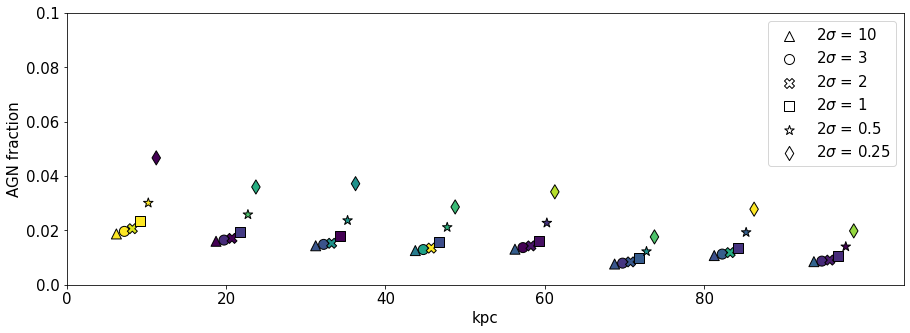

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
# ax.scatter(kpcs, dif_cut, s=100, c=PDF_wid)#, marker=markers)
# ax.set_ylim(0,0.12)
# ax.set_xlabel('kpc')
# ax.set_ylabel('AGN fraction')

# marker = ['^','o','X','s','*','d'] * 6
for i, key in enumerate(dif_cuts):
    kpc_medu = [km+i for km in kpc_meds]
    ax.scatter(kpc_medu, dif_cuts[key], s=100, c=PDF_width[key], marker=marker[i], edgecolors='black')
    ax.scatter(-100,-100, marker=marker[i], s=100, edgecolors='black', facecolor='white', label='2$\sigma$ = '+key)
    # ax.set_title('AGN fractions with different $\sigma$ criteria', fontsize=20)
    ax.set_xlim(0,105)
    ax.set_ylim(0,0.1)
    ax.set_xlabel('kpc', fontsize=15)
    ax.set_ylabel('AGN fraction', fontsize=15)
    ax.legend(fontsize=15)
    # cbar = fig.colorbar(pdat, ax=ax[0], vmax=2, vmin=0)
    # cbar.set_label('mean $2\sigma$', fontsize=15)
    # ax[1].bar(float(key), iso_count[key], label='2$\sigma$ = '+key)
    # ax[1].set_title('$N_{pairs} / N_{iso}$')

ax.set_xticks(np.arange(0,100,20))
ax.set_xticklabels(np.arange(0,100,20),fontsize=15)
ax.set_yticks(np.arange(0,0.11,0.02))
ax.set_yticklabels(np.arange(0,0.11,0.02),fontsize=15)

plt.savefig(PATH+'AP_PP_comparing_sigma.png')

plt.show()

## next plot the difference in AGN fraction at different pair_prob cuts


In [116]:
prob_dat = {}
iso_count = {}
pair_count = {}

In [ ]:
# read in results
sig_cut = 0.25
rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')

In [ ]:
# add an AGN count per pair column:
rdf['mAGN'] = [0]*len(rdf)

LX_AGN = 10**42
rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1

In [119]:
# calculate AGN fractions:

# create bins:
max_dist=100
n_bins=8
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)

# AGN_frac = {}

probc = [0.9, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001, 0]

AGN_frac = {}
prob_dat = {}
iso_count = {}
pair_count = {}
npairs = {}

# sig_cuts = [10,3,2,1,0.5,0.25]
sig_cuts = [0.5,0.25]

for sig_cut in sig_cuts:
    print(sig_cut)
    rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
    # add an AGN count per pair column:
    rdf['mAGN'] = [0]*len(rdf)
    LX_AGN = 10**42
    rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    
    AGN_frac[str(sig_cut)] = np.zeros((len(probc), n_bins))
    npairs[str(sig_cut)] = np.zeros((len(probc),1))

    for i, p in enumerate(probc):
        rdf2 = rdf.loc[ (rdf['pair_prob'] > p) & (rdf['prime_M'] > 10) & (rdf['field'] != 'COS') & (rdf['field'] != 'COSMOS') ]
        npairs[str(sig_cut)][i] = len(rdf2)

        # split data frame up into each bin
        for j, rnge in enumerate(bins):
            # get bin ranges from bins dictionary entries
            info = bins[rnge].split('-')
            low = float(info[0])
            high = float(info[1])

            # sort into bins
            bin_df = rdf2[ (rdf2['kpc_sep'] > low) & (rdf2['kpc_sep'] <= high) ]

            # calculating AGN per pair here
            AGN_frac[str(sig_cut)][i,j] = (sum(bin_df['pair_prob'] * 0.5*bin_df['mAGN']) / (sum(bin_df['pair_prob'])))# * len(bin_df)))

    kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

    prob_dat = AGN_frac
    iso_count[str(sig_cut)] = sum(rdf['iso_count'].unique())
    pair_count = npairs

0.5
0.25


In [ ]:
bin_df

In [ ]:
# # get graphical data
# # pAGN_fracs = [AGN_frac[col] for col in AGN_frac]
# kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

# prob_dat[str(sig_cut)] = AGN_frac
# iso_count[str(sig_cut)] = sum(rdf['iso_count'].unique())
# pair_count[str(sig_cut)] = npairs

In [ ]:
# kpc_meds

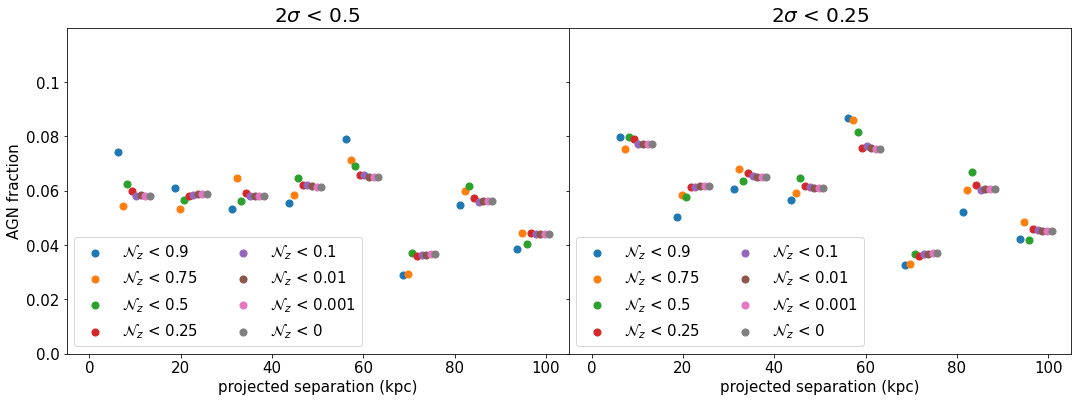

In [146]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharey=True)
fig.subplots_adjust(wspace=0)

for k, key in enumerate(prob_dat):
    for i in range(0,len(prob_dat[key])):
        kpc_medu = [km+(i*1) for km in kpc_meds]
        ax[k].scatter(kpc_medu, prob_dat[key][i], label='$\mathcal{N}_z$ < '+str(probc[i]), s=50)
    #ax[k].set_ylim(0,8e-5)
    ax[k].set_ylim(0,0.12)
    ax[k].set_xlim(-5,105)
    ax[k].set_title('2$\sigma$ < '+key, fontsize=20)
    ax[k].legend(fontsize=15, ncol=2, loc='lower left')
    
ax[0].set_xticks(np.arange(0,105,20))
ax[0].set_xticklabels(np.arange(0,105,20),fontsize=15)
ax[0].set_yticks(np.arange(0,0.12,0.02))
ax[0].set_yticklabels(np.arange(0,0.12,0.02),fontsize=15)

ax[0].set_xlabel('projected separation (kpc)', fontsize=15)
ax[1].set_xlabel('projected separation (kpc)', fontsize=15)
ax[0].set_ylabel('AGN fraction', fontsize=15)


ax[1].set_xticks(np.arange(0,105,20))
ax[1].set_xticklabels(np.arange(0,105,20),fontsize=15)
    
plt.savefig(PATH+'AP_PP_comparing_prob_cuts.png')
    
plt.show()     

### remember this is AGN fraction per pairs ###

## Compare pair and control sample distributions:

In [ ]:
# sig_cut = 0.3
# # rdf = pd.read_csv(PATH+'pair_data_DALE_TEST_'+str(sig_cut)+'.csv')
# rdf = pd.read_csv(PATH+'pair_data_ORIG_'+str(sig_cut)+'.csv')

In [5]:
def make_bins_PDF(max_dist=100, n_bins=10):

    # create bin sizes
    all_bins = {}
    for bn in range(0, n_bins):
        # define limits for each bin
        all_bins[str(bn)] = str((max_dist/n_bins)*bn)+'-'+str((max_dist/n_bins)+(max_dist/n_bins)*bn)
    
    return all_bins

In [308]:
# create bins:
max_dist=150
n_bins=15
resolve = True
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)

# file = 'hmag_cut.csv'
# file = 'no_hmag_cut.csv'
file = 'no_hmag_cut_sig1.csv'
rdf = pd.read_csv(PATH+file)

# add an AGN count per pair column:
rdf['pXAGN'] = [0]*len(rdf)
rdf['iXAGN'] = [0]*len(rdf)
rdf['pXAGN_PR'] = [0]*len(rdf)
rdf['pXAGN_PA'] = [0]*len(rdf)

rdf['pDAGN'] = [0]*len(rdf)
rdf['iDAGN'] = [0]*len(rdf)
rdf['pDAGN_PR'] = [0]*len(rdf)
rdf['pDAGN_PA'] = [0]*len(rdf)

rdf['pDoAGN'] = [0]*len(rdf)
rdf['iDoAGN'] = [0]*len(rdf)
rdf['pDoAGN_PR'] = [0]*len(rdf)
rdf['pDoAGN_PA'] = [0]*len(rdf)

rdf['pStAGN'] = [0]*len(rdf)
rdf['iStAGN'] = [0]*len(rdf)
rdf['pStAGN_PR'] = [0]*len(rdf)
rdf['pStAGN_PA'] = [0]*len(rdf)

LX_AGN = 10**42
rdf.loc[ rdf['prime_LX'] > LX_AGN, 'pXAGN' ] = rdf['pXAGN']+1     # keep these for now but currently not useful...
rdf.loc[ rdf['partner_LX'] > LX_AGN, 'pXAGN' ] = rdf['pXAGN']+1
rdf.loc[ rdf['c1prime_LX'] > LX_AGN, 'iXAGN' ] = rdf['iXAGN']+1
rdf.loc[ rdf['c2prime_LX'] > LX_AGN, 'iXAGN' ] = rdf['iXAGN']+1
rdf.loc[ rdf['c1partner_LX'] > LX_AGN, 'iXAGN' ] = rdf['iXAGN']+1
rdf.loc[ rdf['c2partner_LX'] > LX_AGN, 'iXAGN' ] = rdf['iXAGN']+1
rdf.loc[ rdf['prime_LX'] > LX_AGN, 'pXAGN_PR' ] = 1
rdf.loc[ rdf['partner_LX'] > LX_AGN, 'pXAGN_PA' ] = 1

rdf.loc[ rdf['prime_DALE_AGN_FLAG'] > 0, 'pDAGN' ] = rdf['pDAGN']+1
rdf.loc[ rdf['partner_DALE_AGN_FLAG'] > 0, 'pDAGN' ] = rdf['pDAGN']+1
rdf.loc[ rdf['c1prime_DALE_AGN_FLAG'] > 0, 'iDAGN' ] = rdf['iDAGN']+1
rdf.loc[ rdf['c2prime_DALE_AGN_FLAG'] > 0, 'iDAGN' ] = rdf['iDAGN']+1
rdf.loc[ rdf['c1partner_DALE_AGN_FLAG'] > 0, 'iDAGN' ] = rdf['iDAGN']+1
rdf.loc[ rdf['c2partner_DALE_AGN_FLAG'] > 0, 'iDAGN' ] = rdf['iDAGN']+1
rdf.loc[ rdf['prime_DALE_AGN_FLAG'] > 0, 'pDAGN_PR' ] = 1
rdf.loc[ rdf['partner_DALE_AGN_FLAG'] > 0, 'pDAGN_PA' ] = 1 # just worry about AGN fractions for now

rdf.loc[ rdf['prime_IR_AGN_DON'] == 1, 'pDoAGN' ] = rdf['pDoAGN']+1
rdf.loc[ rdf['partner_IR_AGN_DON'] == 1, 'pDoAGN' ] = rdf['pDoAGN']+1
rdf.loc[ rdf['c1prime_IR_AGN_DON'] == 1, 'iDoAGN' ] = rdf['iDoAGN']+1
rdf.loc[ rdf['c2prime_IR_AGN_DON'] == 1, 'iDoAGN' ] = rdf['iDoAGN']+1
rdf.loc[ rdf['c1partner_IR_AGN_DON'] == 1, 'iDoAGN' ] = rdf['iDoAGN']+1
rdf.loc[ rdf['c2partner_IR_AGN_DON'] == 1, 'iDoAGN' ] = rdf['iDoAGN']+1
rdf.loc[ rdf['prime_IR_AGN_DON'] == 1, 'pDoAGN_PR' ] = 1
rdf.loc[ rdf['partner_IR_AGN_DON'] == 1, 'pDoAGN_PA' ] = 1

rdf.loc[ rdf['prime_IR_AGN_STR'] == 1, 'pStAGN' ] = rdf['pStAGN']+1
rdf.loc[ rdf['partner_IR_AGN_STR'] == 1, 'pStAGN' ] = rdf['pStAGN']+1
rdf.loc[ rdf['c1prime_IR_AGN_STR'] == 1, 'iStAGN' ] = rdf['iStAGN']+1
rdf.loc[ rdf['c2prime_IR_AGN_STR'] == 1, 'iStAGN' ] = rdf['iStAGN']+1
rdf.loc[ rdf['c1partner_IR_AGN_STR'] == 1, 'iStAGN' ] = rdf['iStAGN']+1
rdf.loc[ rdf['c2partner_IR_AGN_STR'] == 1, 'iStAGN' ] = rdf['iStAGN']+1
rdf.loc[ rdf['prime_IR_AGN_STR'] == 1, 'pStAGN_PR' ] = 1
rdf.loc[ rdf['partner_IR_AGN_STR'] == 1, 'pStAGN_PA' ] = 1


rdf = rdf[ (rdf['partner_M'] > 9) & (rdf['prime_z'] < 3) ] # ((rdf['field'] == 'GDS') | (rdf['field'] == 'EGS')) ]
# rdf = rdf[ (rdf['prime_M'] > 10) & (rdf['prime_z'] < 3.0)  & (rdf['field'] == 'COSMOS') ] (rdf['mass_ratio'] > np.log10(4/1))

pAGN_frac = {}
iAGN_frac = {}
pAGN_count, iAGN_count = {}, {} #

tot_pair = {}
tot_iso = {}
DALE_pair_frac = {}
DALE_iso_frac = {}
pDALE_count, iDALE_count = {}, {} #
pDALE_dup_AGN, iDALE_dup_AGN = {}, {} # what is this naming scheme here... count should be all gals and AGN should be # AGN
pDALE_dup_count, pDALE_dup_count = {}, {}


pXAGN_frac, iXAGN_frac = {}, {}
pXAGN_count, iXAGN_count = {}, {}
pDAGN_frac, iDAGN_frac = {}, {}
pDAGN_count, iDAGN_count = {}, {}
pDoAGN_frac, iDoAGN_frac = {}, {}
pDoAGN_count, iDoAGN_count = {}, {}
pStAGN_frac, iStAGN_frac = {}, {}
pStAGN_count, iStAGN_count = {}, {}


pz_bin, pmass_bin, psig_bin = {},{},{}
iz_bin, imass_bin, isig_bin = {},{},{}

# collect distribution of entire data
pz = np.concatenate( (rdf['prime_z'], rdf['partner_z']) )
pmass = np.concatenate( (rdf['prime_M'], rdf['partner_M']) )
psig = np.concatenate( (rdf['prime_PDFsig'], rdf['partner_PDFsig']) )
iz = np.concatenate( (rdf.loc[ rdf['c1prime_z']!=-99, 'c1prime_z' ], rdf.loc[ rdf[ 'c2prime_z']!=-99, 'c2prime_z' ], 
                      rdf.loc[ rdf['c1partner_z']!=-99, 'c1partner_z' ], rdf.loc[ rdf['c2partner_z']!=-99, 'c2partner_z'] ) )
imass = np.concatenate( (rdf.loc[ rdf['c1prime_M']!=-99, 'c1prime_M' ], rdf.loc[ rdf[ 'c2prime_M']!=-99, 'c2prime_M' ], 
                      rdf.loc[ rdf['c1partner_M']!=-99, 'c1partner_M' ], rdf.loc[ rdf['c2partner_M']!=-99, 'c2partner_M'] ) )
isig = np.concatenate( (rdf.loc[ rdf['c1prime_sig']!=-99, 'c1prime_sig' ], rdf.loc[ rdf[ 'c2prime_sig']!=-99, 'c2prime_sig' ], 
                      rdf.loc[ rdf['c1partner_sig']!=-99, 'c1partner_sig' ], rdf.loc[ rdf['c2partner_sig']!=-99, 'c2partner_sig'] ) )


# split data frame up into each bin
for i, rnge in enumerate(bins):
    # get bin ranges from bins dictionary entries
    info = bins[rnge].split('-')
    low = float(info[0])
    high = float(info[1])

    # sort into bins
    bin_df = rdf[ (rdf['kpc_sep'] > low) & (rdf['kpc_sep'] <= high) ]

    # calculating AGN per pair here                   #beware                     # this seems to be area of difference...
    pAGN_frac[bins[rnge]] = sum(bin_df['pair_prob'] * 0.5*bin_df['pXAGN']) / (sum(bin_df['pair_prob']))# * len(bin_df))
    # pAGN_frac[bins[rnge]] = sum(bin_df['pair_prob'] * 0.5*bin_df['mAGN']) / (len(bin_df))
#     iAGN_frac[bins[rnge]] = ( (len(bin_df.loc[bin_df['c1prime_LX'] > LX_AGN]) + len(bin_df.loc[bin_df['c2prime_LX'] > LX_AGN]) +
#                              len(bin_df.loc[bin_df['c1partner_LX'] > LX_AGN]) + len(bin_df.loc[bin_df['c2partner_LX'] > LX_AGN])) /
#                              (len(bin_df.loc[bin_df['c1prime_LX'] != -99]) + len(bin_df.loc[bin_df['c2prime_LX'] != -99]) +
#                               len(bin_df.loc[bin_df['c1partner_LX'] != -99]) + len(bin_df.loc[bin_df['c2partner_LX'] != -99])) )
    
    # colect distribution information for each bin
    pz_bin[bins[rnge]] = np.concatenate( (bin_df['prime_z'], bin_df['partner_z']) )
    pmass_bin[bins[rnge]] = np.concatenate( (bin_df['prime_M'], bin_df['partner_M']) )
    psig_bin[bins[rnge]] = np.concatenate( (bin_df['prime_PDFsig'], bin_df['partner_PDFsig']) )
    iz_bin[bins[rnge]] = np.concatenate( (bin_df.loc[bin_df['c1prime_z'] != -99, 'c1prime_z'], 
                                          bin_df.loc[bin_df['c2prime_z'] != -99, 'c2prime_z'], 
                                          bin_df.loc[bin_df['c1partner_z'] != -99, 'c1partner_z'],
                                          bin_df.loc[bin_df['c2partner_z'] != -99, 'c2partner_z']) )
    imass_bin[bins[rnge]] = np.concatenate( (bin_df.loc[bin_df['c1prime_M'] != -99, 'c1prime_M'], 
                                          bin_df.loc[bin_df['c2prime_M'] != -99, 'c2prime_M'], 
                                          bin_df.loc[bin_df['c1partner_M'] != -99, 'c1partner_M'],
                                          bin_df.loc[bin_df['c2partner_M'] != -99, 'c2partner_M']) )
    isig_bin[bins[rnge]] = np.concatenate( (bin_df.loc[bin_df['c1prime_sig'] != -99, 'c1prime_sig'], 
                                          bin_df.loc[bin_df['c2prime_sig'] != -99, 'c2prime_sig'], 
                                          bin_df.loc[bin_df['c1partner_sig'] != -99, 'c1partner_sig'],
                                          bin_df.loc[bin_df['c2partner_sig'] != -99, 'c2partner_sig']) )
    
    # tot_iso[bins[rnge]] =  [(len(bin_df.loc[bin_df['c1prime_ID'] != -99]) + len(bin_df.loc[bin_df['c2prime_ID'] != -99]) +
    #                           len(bin_df.loc[bin_df['c1partner_ID'] != -99]) + len(bin_df.loc[bin_df['c2partner_ID'] != -99]))]
    
    ###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###
    
    # resolve duplicates <- make a switch for this, and do it for all AGN count methods...
    if resolve == True:
        bin_probs = []
        bin_XAGN, bin_DAGN, bin_DoAGN, bin_StAGN = [], [], [], []
        for field in bin_df['field'].unique():
            # stack prime partner indices, pair_prob, AGN (0 or 1)
            all_idx = np.concatenate( (bin_df.loc[bin_df['field'] == field, 'prime_index'], bin_df.loc[bin_df['field'] == field, 'partner_index']) )
            all_prob = np.concatenate( (bin_df.loc[bin_df['field'] == field, 'pair_prob'], bin_df.loc[bin_df['field'] == field, 'pair_prob']) )
            all_XAGN = np.concatenate( (bin_df.loc[bin_df['field'] == field, 'pXAGN_PR'], bin_df.loc[bin_df['field'] == field, 'pXAGN_PA']) )
            all_DAGN = np.concatenate( (bin_df.loc[bin_df['field'] == field, 'pDAGN_PR'], bin_df.loc[bin_df['field'] == field, 'pDAGN_PA']) )
            all_DoAGN = np.concatenate( (bin_df.loc[bin_df['field'] == field, 'pDoAGN_PR'], bin_df.loc[bin_df['field'] == field, 'pDoAGN_PA']) )
            all_StAGN = np.concatenate( (bin_df.loc[bin_df['field'] == field, 'pStAGN_PR'], bin_df.loc[bin_df['field'] == field, 'pStAGN_PA']) )
            # sort out duplicates
            unq_id, sort_idx, counts = np.unique(all_idx, return_index=True, return_counts=True)

            for i in range(0, len(counts)):
                if counts[i] > 1:
                    dup_idx = unq_id[i]
                    dup_prob = all_prob[np.where(all_idx == dup_idx)]
                    max_prob = max(dup_prob)
                    all_prob[np.where(all_idx == dup_idx)] = max_prob

            sort_prob = all_prob[sort_idx]
            sort_XAGN = all_XAGN[sort_idx]
            sort_DAGN = all_DAGN[sort_idx]
            sort_DoAGN = all_DoAGN[sort_idx]
            sort_StAGN = all_StAGN[sort_idx]
            bin_probs.append(sort_prob)
            bin_XAGN.append(sort_XAGN)
            bin_DAGN.append(sort_DAGN)
            bin_DoAGN.append(sort_DoAGN)
            bin_StAGN.append(sort_StAGN)

        bin_probs = np.concatenate(np.array(bin_probs, dtype=object))
        bin_XAGN = np.concatenate(np.array(bin_XAGN, dtype=object))
        bin_DAGN = np.concatenate(np.array(bin_DAGN, dtype=object))
        bin_DoAGN = np.concatenate(np.array(bin_DoAGN, dtype=object))
        bin_StAGN = np.concatenate(np.array(bin_StAGN, dtype=object))
        
        # store counts for table
        pXAGN_count[bins[rnge]] = [sum(bin_probs*bin_XAGN)]
        pDAGN_count[bins[rnge]] = [sum(bin_probs*bin_DAGN)]
        pDoAGN_count[bins[rnge]] = [sum(bin_probs*bin_DoAGN)]
        pStAGN_count[bins[rnge]] = [sum(bin_probs*bin_StAGN)]
        
        # calculate AGN fractions
        pXAGN_frac[bins[rnge]] = [ sum(bin_probs*bin_XAGN) / sum(bin_probs) ]
        pDAGN_frac[bins[rnge]] = [ sum(bin_probs*bin_DAGN) / sum(bin_probs) ]
        pDoAGN_frac[bins[rnge]] = [ sum(bin_probs*bin_DoAGN) / sum(bin_probs) ]
        pStAGN_frac[bins[rnge]] = [ sum(bin_probs*bin_StAGN) / sum(bin_probs) ]
        
        # will need to redefine total counts as well (at least now for pairs)
        tot_pair[bins[rnge]] = [sum(bin_probs)]
        
    else:
        bin_probs = np.concatenate((bin_df['pair_prob'], bin_df['pair_prob']))
        bin_XAGN = np.concatenate((bin_df['pXAGN_PR'], bin_df['pXAGN_PA']))
        bin_DAGN = np.concatenate((bin_df['pDAGN_PR'], bin_df['pDAGN_PA']))
        bin_DoAGN = np.concatenate((bin_df['pDoAGN_PR'], bin_df['pDoAGN_PA']))
        bin_StAGN = np.concatenate((bin_df['pStAGN_PR'], bin_df['pStAGN_PA']))
        
        # store counts for table
        pXAGN_count[bins[rnge]] = [sum(bin_probs*bin_XAGN)]
        pDAGN_count[bins[rnge]] = [sum(bin_probs*bin_DAGN)]
        pDoAGN_count[bins[rnge]] = [sum(bin_probs*bin_DoAGN)]
        pStAGN_count[bins[rnge]] = [sum(bin_probs*bin_StAGN)]
        
        # calculate AGN fractions
        pXAGN_frac[bins[rnge]] = [ sum(bin_probs*bin_XAGN) / sum(bin_probs) ]
        pDAGN_frac[bins[rnge]] = [ sum(bin_probs*bin_DAGN) / sum(bin_probs) ]
        pDoAGN_frac[bins[rnge]] = [ sum(bin_probs*bin_DoAGN) / sum(bin_probs) ]
        pStAGN_frac[bins[rnge]] = [ sum(bin_probs*bin_StAGN) / sum(bin_probs) ]
        
        # total counts are
        tot_pair[bins[rnge]] = [sum(bin_probs)]
        
    ###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###
    



    
# get graphical data
pXAGN_fracs = np.array([pXAGN_frac[col] for col in pXAGN_frac])
pDAGN_fracs = np.array([pDAGN_frac[col] for col in pDAGN_frac])
pDoAGN_fracs = np.array([pDoAGN_frac[col] for col in pDoAGN_frac])
pStAGN_fracs = np.array([pStAGN_frac[col] for col in pStAGN_frac])

kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]
# define violin plot width
vwidth = float((bins['0'].split('-'))[1]) - float((bins['0'].split('-'))[0])
# AGN_enh = (pAGN_fracs) /(iAGN_fracs)

pz_bins = [pz_bin[col] for col in pz_bin]
pmass_bins = [pmass_bin[col] for col in pmass_bin]
psig_bins = [psig_bin[col] for col in psig_bin]
iz_bins = [iz_bin[col] for col in iz_bin]
imass_bins = [imass_bin[col] for col in imass_bin]
isig_bins = [isig_bin[col] for col in isig_bin]

tot_pairs = np.array([tot_pair[col] for col in tot_pair])
tot_isos = np.array([tot_iso[col] for col in tot_iso])

print('Done!')


Done!


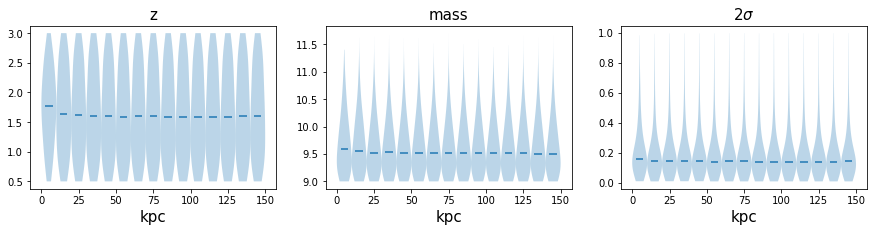

In [309]:
# plot distributions
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
# ax[0,0].hist(pz, bins=25, histtype='step', density=True, label='pair')
# ax[0,0].hist(iz, bins=25, histtype='step', density=True, label='iso')
# ax[0,0].set_xlabel('z', fontsize=15)
# ax[0,0].legend()

ax[0].violinplot(pz_bins, kpc_meds,  points=100, widths=vwidth, showmeans=False,
                     showextrema=False, showmedians=True, bw_method=0.5)
# ax[0,1].violinplot(iz_bins, kpc_meds,  points=100, widths=vwidth, showmeans=False,
#                      showextrema=False, showmedians=True, bw_method=0.5)
ax[0].set_xlabel('kpc', fontsize=15)
ax[0].set_title('z', fontsize=15)

# ax[1,0].hist(pmass, bins=25, histtype='step', density=True, label='pair')
# ax[1,0].hist(imass, bins=25, histtype='step', density=True, label='iso')
# ax[1,0].set_xlabel('stellar mass', fontsize=15)
# ax[1,0].legend()

ax[1].violinplot(pmass_bins, kpc_meds,  points=100, widths=vwidth, showmeans=False,
                     showextrema=False, showmedians=True, bw_method=0.5)
# ax[1,1].violinplot(imass_bins, kpc_meds,  points=100, widths=vwidth, showmeans=False,
#                      showextrema=False, showmedians=True, bw_method=0.5)
ax[1].set_xlabel('kpc', fontsize=15)
ax[1].set_title('mass', fontsize=15)

# ax[2,0].hist(psig, bins=25, histtype='step', density=True, label='pair')
# ax[2,0].hist(isig, bins=25, histtype='step', density=True, label='iso')
# ax[2,0].set_xlabel('2$\sigma$', fontsize=15)
# ax[2,0].legend()

ax[2].violinplot(psig_bins, kpc_meds,  points=100, widths=vwidth, showmeans=False,
                     showextrema=False, showmedians=True, bw_method=0.5)
# ax[2,1].violinplot(isig_bins, kpc_meds,  points=100, widths=vwidth, showmeans=False,
#                      showextrema=False, showmedians=True, bw_method=0.5)
ax[2].set_xlabel('kpc', fontsize=15)
ax[2].set_title('$2\sigma$', fontsize=15)

# plt.savefig(PATH+'pp_150kpc_distr.png')

plt.show()

In [310]:
# collect count numbers in a df <- FORGET ABOUT ISOLATED GALAXIES FOR NOW
all_pairs_df = pd.DataFrame.from_dict(tot_pair)
# all_iso_df = pd.DataFrame.from_dict(tot_iso)
pXAGN_df = pd.DataFrame.from_dict(pXAGN_count)
# iXRAY_df = pd.DataFrame.from_dict(iAGN_count)
pDAGN_df = pd.DataFrame.from_dict(pDAGN_count)
# iDALE_df = pd.DataFrame.from_dict(iDALE_count)
pDoAGN_df = pd.DataFrame.from_dict(pDoAGN_count)
# iDON_df = pd.DataFrame.from_dict(iDON_count)
pStAGN_df = pd.DataFrame.from_dict(pStAGN_count)
# iSTR_df = pd.DataFrame.from_dict(iSTR_count)

df = pd.concat([all_pairs_df, pXAGN_df, pDAGN_df, pDoAGN_df, pStAGN_df], ignore_index = True, axis=0)
df = df.rename(index={0: 'Paired Gals', 1: 'Paired X-ray AGN', 2: 'Paired Dale AGN', 
                      3: 'Paired Donley AGN', 4:'Paired Stern AGN'})

# df = pd.concat([all_pairs_df, pXRAY_df, pDON_df, pSTR_df, pDALE_df,
#                all_iso_df, iXRAY_df, iDON_df, iSTR_df, iDALE_df], ignore_index = True, axis=0)

# df = df.rename(index={0: 'Paired Gals', 1: 'Paired X-ray AGN', 2: 'Paired IR Don AGN', 3: 'Paired IR Str AGN', 4:'Paired Dale AGN',
#                 5: 'Iso Gals', 6: 'Iso X-ray AGN', 7: 'Iso IR Don AGN', 8: 'Iso ID Str AGN', 9: 'Iso Dale AGN'})
df

,0.0-10.0,10.0-20.0,20.0-30.0,30.0-40.0,40.0-50.0,50.0-60.0,60.0-70.0,70.0-80.0,80.0-90.0,90.0-100.0,100.0-110.0,110.0-120.0,120.0-130.0,130.0-140.0,140.0-150.0
Paired Gals,541.638965,1573.512795,1998.166288,2310.036716,2512.718794,2850.261923,3144.613136,3424.425375,3698.580675,3911.661346,4325.088048,4588.072085,4883.018217,5125.288067,5521.336982
Paired X-ray AGN,8.672394,37.765951,39.024342,36.586534,45.990901,55.667338,42.686374,44.965814,62.062154,50.724922,48.582632,63.122170,60.310783,68.838204,81.982459
Paired Dale AGN,14.430447,38.382351,46.571647,50.016544,50.936466,59.307279,49.621900,58.026497,70.672388,61.365788,61.962455,72.914680,79.632664,78.893583,89.484586
Paired Donley AGN,11.334920,19.659255,16.600364,10.841530,23.466374,32.849196,23.042641,20.795076,26.582814,26.223237,23.633094,29.266597,31.823767,38.035913,41.441271
Paired Stern AGN,34.245662,80.761408,93.174333,87.947233,106.680569,122.676051,121.054997,117.638032,138.851385,146.891539,152.442612,169.141759,163.623719,183.958160,216.784874


In [311]:
def binomial_err(c, k, n):
    p_lower = dist.beta.ppf((1-c)/2., k+1, n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2., k+1, n-k+1)
    return p_lower, p_upper

In [312]:
# calculate 95% binomial confidence intervals based on average AGN fracs and counts
c = 0.683 #(1 sigma)
pX_up, pX_lo, pX_fr = {}, {}, {}                     # upper, lower, and frac
pD_up, pD_lo, pD_fr = {}, {}, {}
pDo_up, pDo_lo, pDo_fr = {}, {}, {}
pSt_up, pSt_lo, pSt_fr = {}, {}, {}

# loop through each col of df above:
for col in df.columns:
    p_n = df[col].loc['Paired Gals']
    # i_n = df[col].loc['Iso Gals']
    # X-ray first
    k_pX = df[col].loc['Paired X-ray AGN']
    pX_lo0, pX_up0 = binomial_err(c, k_pX, p_n)             # function returns y coordinates, not distance from point
    pX_lo[col] = (k_pX/p_n) - pX_lo0
    pX_up[col] = pX_up0 - (k_pX/p_n)
    pX_fr[col] = (k_pX/p_n)
    # k_XRAY_ISO = df[col].loc['Iso X-ray AGN']
    # plXRAY_ISO, puXRAY_ISO = binomial_err(c, k_XRAY_ISO, n_ISO)
    # lXRAY_ISO[col] = (k_XRAY_ISO/n_ISO) - plXRAY_ISO
    # uXRAY_ISO[col] = puXRAY_ISO - (k_XRAY_ISO/n_ISO)
    # mXRAY_ISO[col] =  (k_XRAY_ISO/n_ISO)
    
    # DALE AGN
    k_pD = df[col].loc['Paired Dale AGN']
    pD_lo0, pD_up0 = binomial_err(c, k_pD, p_n)
    pD_lo[col] = (k_pD/p_n) - pD_lo0
    pD_up[col] = pD_up0 - (k_pD/p_n)
    pD_fr[col] = (k_pD/p_n)
    
    # DONLEY IR
    k_pDo = df[col].loc['Paired Donley AGN']
    pDo_lo0, pDo_up0 = binomial_err(c, k_pDo, p_n)
    pDo_lo[col] = (k_pDo/p_n) - pDo_lo0
    pDo_up[col] = pDo_up0 - (k_pDo/p_n)
    pDo_fr[col] = (k_pDo/p_n)
    # k_DON_ISO = df[col].loc['Mean Iso IR Don AGN']
    # plDON_ISO, puDON_ISO = binomial_err(c, k_DON_ISO, n_ISO)
    # lDON_ISO[col] = (k_DON_ISO/n_ISO) - plDON_ISO
    # uDON_ISO[col] = puDON_ISO - (k_DON_ISO/n_ISO)
    # mDON_ISO[col] = (k_DON_ISO/n_ISO)
    
    # STERN IR
    k_pSt = df[col].loc['Paired Stern AGN']
    pSt_lo0, pSt_up0 = binomial_err(c, k_pSt, p_n)
    pSt_lo[col] = (k_pSt/p_n) - pSt_lo0
    pSt_up[col] = pSt_up0 - (k_pSt/p_n)
    pSt_fr[col] = (k_pSt/p_n)

# AGN_enh_err = AGN_enh * np.sqrt( (pAGN_err/pAGN_fracs)**2 + (iAGN_err/pAGN_fracs)**2 )

In [313]:
# prepare for violin plots
pX_uerr = [pX_up[col] for col in pX_up]
pX_lerr = [pX_lo[col] for col in pX_lo]
pX_fr = [pX_fr[col] for col in pX_fr]
# idata_uerr = [uXRAY_ISO[col] for col in uXRAY_ISO]
# idata_lerr = [lXRAY_ISO[col] for col in lXRAY_ISO]
# idata_m = [mXRAY_ISO[col] for col in mXRAY_ISO]

pD_uerr = [pD_up[col] for col in pD_up]
pD_lerr =  [pD_lo[col] for col in pD_lo]
pD_fr = [pD_fr[col] for col in pD_fr]
# iDON_uerr = [uDON_ISO[col] for col in uDON_ISO]
# iDON_lerr =  [lDON_ISO[col] for col in lDON_ISO]
# iDON_m = [mDON_ISO[col] for col in mDON_ISO]

pDo_uerr = [pDo_up[col] for col in pDo_up]
pDo_lerr =  [pDo_lo[col] for col in pDo_lo]
pDo_fr = [pDo_fr[col] for col in pDo_fr]
# iDALE_uerr = [uDALE_ISO[col] for col in uDALE_ISO]
# iDALE_lerr =  [lDALE_ISO[col] for col in lDALE_ISO]
# iDALE_m = [mDALE_ISO[col] for col in mDALE_ISO]

pSt_uerr = [pSt_up[col] for col in pSt_up]
pSt_lerr =  [pSt_lo[col] for col in pSt_lo]
pSt_fr = [pSt_fr[col] for col in pSt_fr]

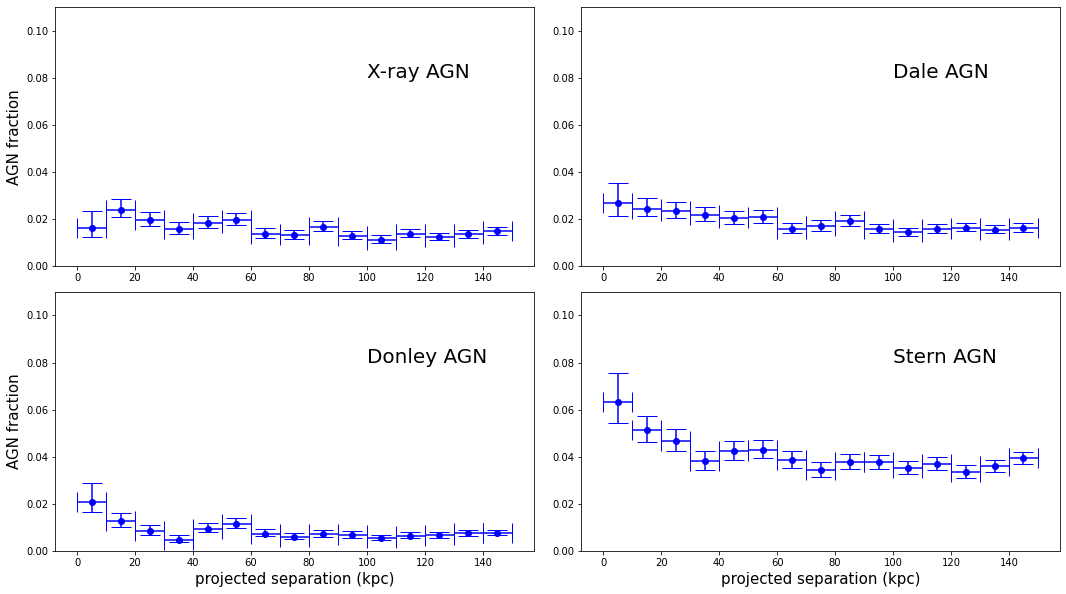

In [314]:
# plot AGN fractions / enhancement:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,10))#, sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.1)
# X-ray
ax[0,0].scatter(kpc_meds, pX_fr, color='blue')
ax[0,0].errorbar(kpc_meds, pX_fr, yerr=(pX_lerr,pX_uerr), xerr=vwidth/2, linestyle="None", capsize=10, color='blue')
ax[0,0].set_ylim(0, 0.11)
ax[0,0].set_ylabel('AGN fraction', fontsize=15)
# ax[0,0].set_xlabel('projected separation (kpc)', fontsize=15)
ax[0,0].text(100,0.08,'X-ray AGN', fontsize=20)

# Dale
ax[0,1].scatter(kpc_meds, pD_fr, color='blue')
ax[0,1].errorbar(kpc_meds, pD_fr, yerr=(pD_lerr,pD_uerr), xerr=vwidth/2, linestyle="None", capsize=10, color='blue')
ax[0,1].set_ylim(0, 0.11)
# ax[0,1].set_xlabel('projected separation (kpc)', fontsize=15)
ax[0,1].text(100,0.08,'Dale AGN', fontsize=20)

# Donley
ax[1,0].scatter(kpc_meds, pDo_fr, color='blue')
ax[1,0].errorbar(kpc_meds, pDo_fr, yerr=(pDo_lerr,pDo_uerr), xerr=vwidth/2, linestyle="None", capsize=10, color='blue')
ax[1,0].set_ylim(0, 0.11)
ax[1,0].set_xlabel('projected separation (kpc)', fontsize=15)
ax[1,0].set_ylabel('AGN fraction', fontsize=15)
ax[1,0].text(100,0.08,'Donley AGN', fontsize=20)

# Stern
ax[1,1].scatter(kpc_meds, pSt_fr, color='blue')
ax[1,1].errorbar(kpc_meds, pSt_fr, yerr=(pSt_lerr,pSt_uerr), xerr=vwidth/2, linestyle="None", capsize=10, color='blue')
ax[1,1].set_ylim(0, 0.11)
ax[1,1].set_xlabel('projected separation (kpc)', fontsize=15)
ax[1,1].text(100,0.08,'Stern AGN', fontsize=20)



# ax[0].set_xticks(np.arange(0,150,20))
# ax[0].set_xticklabels(np.arange(0,150,20),fontsize=15)
# ax[0].set_yticks(np.arange(0,0.12,0.02))
# ax[0].set_yticklabels(np.arange(0,0.12,0.02),fontsize=15)


# ax[1].set_xticks(np.arange(0,150,20))
# ax[1].set_xticklabels(np.arange(0,150,20),fontsize=15)

# plt.savefig(PATH+'AP_PP_150kpc.png')
plt.show()

In [315]:
pDoAGN_frac

{'0.0-10.0': [0.02092707576717779],
 '10.0-20.0': [0.01249386418824921],
 '20.0-30.0': [0.008307799298135318],
 '30.0-40.0': [0.004693228589591967],
 '40.0-50.0': [0.009339037090415095],
 '50.0-60.0': [0.011524974575734941],
 '60.0-70.0': [0.007327655366666413],
 '70.0-80.0': [0.00607257373804862],
 '80.0-90.0': [0.007187301344040817],
 '90.0-100.0': [0.006703861779277511],
 '100.0-110.0': [0.00546418795601644],
 '110.0-120.0': [0.0063788441209755445],
 '120.0-130.0': [0.006517232841180561],
 '130.0-140.0': [0.007421224417950963],
 '140.0-150.0': [0.0075056587506130805]}

In [182]:
# psig_bins